Mounted at /content/drive


In [10]:
import pandas as pd
import numpy as np
import os
import cv2
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten
import torch
from torch.nn.functional import relu
import torch.nn as nn

In [11]:
image_input = torch.load('imageTensor_correct.pt')
move_inputs_y = torch.load('moveTensor_correct.pt')
arm_input = torch.load('armTensor_correct.pt')

tensor(4)


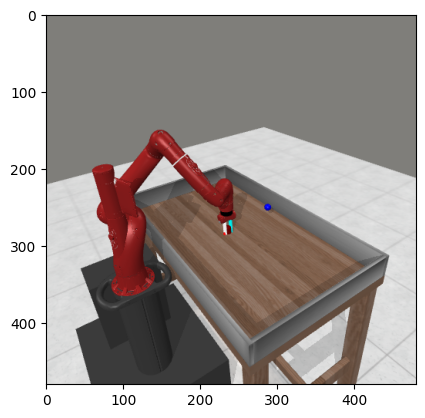

In [12]:
import matplotlib.pyplot as plt
print(move_inputs_y[27])
plt.imshow(image_input[27].permute(1,2,0).int().detach().numpy())

In [13]:
torch.backends.mps.is_available()

True

In [14]:
print(image_input.dtype)
print(move_inputs_y.dtype)
print(arm_input.dtype)

torch.float32
torch.int64
torch.float64


In [15]:
dataset = torch.utils.data.TensorDataset(image_input, arm_input, move_inputs_y)
trainloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

In [16]:
class RoboNet(Module):

    def __init__(self, classes) -> None:
        super(RoboNet, self).__init__()

        self.convLayer1 = Conv2d(in_channels=3, out_channels=32, kernel_size=(4,4))
        self.maxpoolLayer1 = MaxPool2d(kernel_size=(3,3), stride=(4,4))
        self.convLayer2 = Conv2d(in_channels=32, out_channels=64, kernel_size=(4,4))
        self.maxpoolLayer2 = MaxPool2d(kernel_size=(3,3), stride=(4,4))
        self.convLayer3 = Conv2d(in_channels=64, out_channels=96, kernel_size=(4,4))
        self.maxpoolLayer3 = MaxPool2d(kernel_size=(3,3), stride=(4,4))
        self.fc1 = Linear(in_features= 3456 + 4, out_features=64)
        self.fc2 = Linear(in_features=64, out_features=32)
        self.fc3 = Linear(in_features=32, out_features=classes)


    def forward(self, inp, pos_grip, batch_num):

        x = self.maxpoolLayer1(relu(self.convLayer1(inp)))
        x = self.maxpoolLayer2(relu(self.convLayer2(x)))
        x = self.maxpoolLayer3(relu(self.convLayer3(x)))

        x = flatten(x, 1)

        if(batch_num % 23 == 0):
          print("Max val: ", torch.max(x))
          print("Min val: ", torch.min(x))
          print("Avg val: ", torch.mean(x))
          print("Median val: ", torch.median(x))

        # Check size of values in x after the flatten to help decide scaling for next concat values
        x = torch.cat((x, pos_grip.float()), dim=1)

        x = relu(self.fc1(x))
        x = relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [17]:
import torch.optim as optim
device = "mps"
rn = RoboNet(8).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(rn.parameters(), lr=0.005, momentum=0.9)

weights = torch.load('gpu-20epoch-newdata.pth')
rn.load_state_dict(weights)

<All keys matched successfully>

In [19]:
for epoch in range(1, 6):

  batch = 1
  loss_val = 0.0
  total_batches = len(trainloader)

  for xbatch, armbatch ,ybatch in trainloader:
    
    xbatch = xbatch / 255.0
    xbatch = xbatch.to(device)
    armbatch = armbatch.to(torch.float32).to(device)
    ybatch = ybatch.to(device)
    
    optimizer.zero_grad()
    outputs = rn(xbatch, armbatch, batch)
    loss = criterion(outputs, ybatch.reshape(-1))
      
    loss.backward()
    optimizer.step()
    loss_val += loss.item()
    if(batch % 58 == 0):
      print('-' * batch , " ", batch , "/", total_batches)
    batch +=1

  print("Results of epoch: ", epoch, " Loss: ", loss_val)
  
  
torch.save(rn.state_dict(), 'gpu-25epoch-newdata.pth')

Max val:  tensor(6.0914, device='mps:0', grad_fn=<MaxBackward1>)
Min val:  tensor(0., device='mps:0', grad_fn=<MinBackward1>)
Avg val:  tensor(0.1244, device='mps:0', grad_fn=<MeanBackward0>)
Median val:  tensor(0., device='mps:0', grad_fn=<MedianBackward0>)
Max val:  tensor(4.5307, device='mps:0', grad_fn=<MaxBackward1>)
Min val:  tensor(0., device='mps:0', grad_fn=<MinBackward1>)
Avg val:  tensor(0.1127, device='mps:0', grad_fn=<MeanBackward0>)
Median val:  tensor(0., device='mps:0', grad_fn=<MedianBackward0>)
----------------------------------------------------------   58 / 119
Max val:  tensor(4.9631, device='mps:0', grad_fn=<MaxBackward1>)
Min val:  tensor(0., device='mps:0', grad_fn=<MinBackward1>)
Avg val:  tensor(0.0979, device='mps:0', grad_fn=<MeanBackward0>)
Median val:  tensor(0., device='mps:0', grad_fn=<MedianBackward0>)
Max val:  tensor(5.2268, device='mps:0', grad_fn=<MaxBackward1>)
Min val:  tensor(0., device='mps:0', grad_fn=<MinBackward1>)
Avg val:  tensor(0.1333, de